In [ ]:
import keras
from keras import layers
from keras import callbacks
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import pandas as pd

In [ ]:
from tensorflow.keras.utils import to_categorical

#Clone and load mtg-jamendo-dataset instrument labels

In [ ]:
!git clone https://github.com/MTG/mtg-jamendo-dataset.git


Cloning into 'mtg-jamendo-dataset'...
remote: Enumerating objects: 899, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 899 (delta 28), reused 38 (delta 10), pack-reused 821
Receiving objects: 100% (899/899), 38.03 MiB | 30.57 MiB/s, done.
Resolving deltas: 100% (513/513), done.


In [ ]:
cd mtg-jamendo-dataset/scripts

/content/mtg-jamendo-dataset/scripts


In [ ]:
import commons

In [ ]:
input_file = '../data/splits/split-0/autotagging_instrument-train.tsv'
tracksTrain, tagsTrain, extraTrain = commons.read_file(input_file)

Reading: 14395 tracks, 3316 albums, 1196 artists


In [ ]:
input_file = '../data/splits/split-0/autotagging_instrument-validation.tsv'
tracksVal, tagsVal, extraVal = commons.read_file(input_file)

Reading: 5466 tracks, 1221 albums, 405 artists


In [ ]:
input_file = '../data/splits/split-0/autotagging_instrument-test.tsv'
tracksTest, tagsTest, extraTest = commons.read_file(input_file)

Reading: 5115 tracks, 1135 albums, 402 artists


#Dataset Analysis

In [ ]:
trainDF = pd.DataFrame(tracksTrain).T

In [ ]:
trainDF

,artist_id,album_id,path,duration,tags,genre,instrument,mood/theme
382,20,46,82/382.mp3,211.1,[instrument---voice],{},{voice},{}
383,20,46,83/383.mp3,113.1,[instrument---voice],{},{voice},{}
384,20,46,84/384.mp3,115.7,[instrument---voice],{},{voice},{}
386,20,46,86/386.mp3,103.4,[instrument---voice],{},{voice},{}
387,20,46,87/387.mp3,257.1,[instrument---voice],{},{voice},{}
...,...,...,...,...,...,...,...,...
1422056,496314,165847,56/1422056.mp3,516,[instrument---computer],{},{computer},{}
1422057,496314,165847,57/1422057.mp3,374.9,[instrument---computer],{},{computer},{}
1422058,496314,165847,58/1422058.mp3,315.8,[instrument---computer],{},{computer},{}
1422059,496314,165847,59/1422059.mp3,201.3,[instrument---computer],{},{computer},{}


In [ ]:
trainDF['instrument'][1030900])

{'bass', 'drums', 'electricguitar', 'guitar'}

In [ ]:
 import seaborn as sns

In [ ]:
instrumentCounts = []
for k in tagsTrain['instrument']:
  instrumentCounts.append(len(tagsTrain['instrument'][k]))
instruments = list(tagsTrain['instrument'].keys())

In [ ]:
instrumentDF = pd.DataFrame(list(zip(instruments, instrumentCounts)), columns=['instrument', 'count'])

In [ ]:
instrumentDF = instrumentDF.loc[instrumentDF['count'] > 950]

In [ ]:
instrumentDF = instrumentDF.reset_index(drop=True)

In [55]:
instrumentDF

,instrument,count
0,synthesizer,4356
1,piano,4194
2,guitar,2915
3,keyboard,1185
4,bass,3121
5,drummachine,969
6,drums,3373
7,electricguitar,2309
8,acousticguitar,990


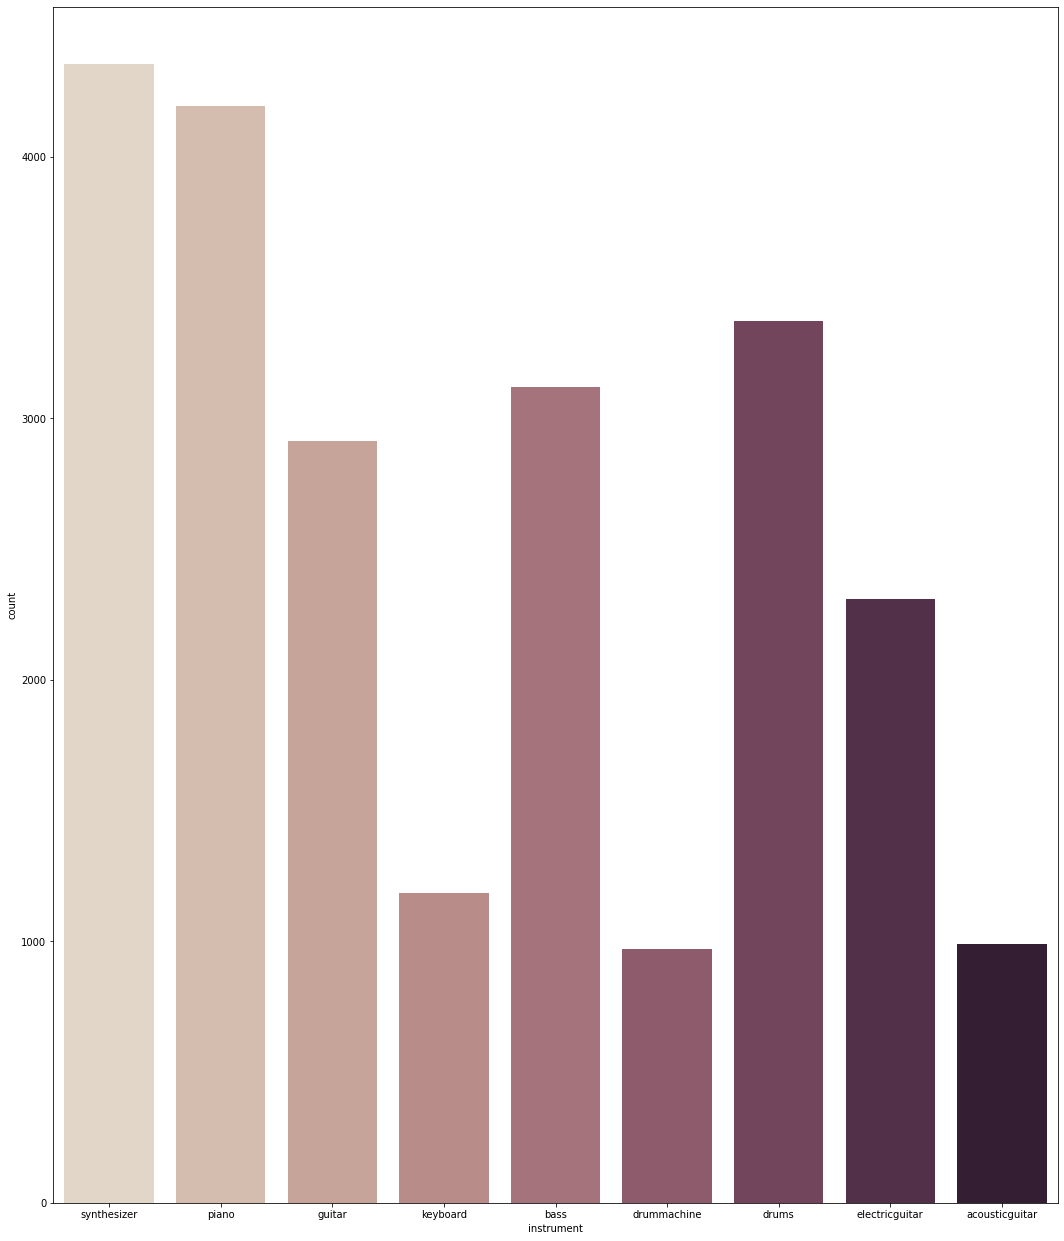

In [ ]:
plt.figure(figsize=(18,22))
sns.barplot(x='instrument', y='count', palette="ch:.25", data=instrumentDF.loc[instrumentDF['count'] > 950])

# Get tracks with top instruments
### Set trainX to filenames to feed to custom data generator
### Set trainY to one hot encodings of labels

In [59]:
tracks = {}
for key in tracksTrain:
  for instrument in tracksTrain[key]['instrument']:
    if instrument in instrumentDF['instrument'].values:
      tracks[key] = tracksTrain[key]
      tracks[key]['label'] = np.sum(
          to_categorical(instrumentDF.loc[instrumentDF['instrument'].isin(tracksTrain[key]['instrument'])].index.to_list(), num_classes=len(instrumentDF)), axis=0)
      break

In [69]:
tracksDF = pd.DataFrame(tracks).T

In [79]:
trainX = np.array(list(tracks.keys()))
trainY = np.array(tracksDF['label'].to_list())

In [80]:
trainY.shape

(12574, 9)

#Connecting to the dataset downloaded to my Google Drive
##Unzip all subsets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -qq "/content/drive/My Drive/Colab Notebooks/CompSoundMusic/mtg-jamendo-dataset/mel-spectrogramstrain...SetMTG.zip" -d "/content/drive/My Drive/Colab Notebooks/CompSoundMusic/mtg-jamendo-dataset/melspecs0"

#First example from the MTG-Jamendo-Dataset

In [ ]:
firstSample = np.load("/content/drive/My Drive/Colab Notebooks/CompSoundMusic/mtg-jamendo-dataset/melspecs0/Volumes/HD-HSU2/multiInstrumentDetection/mel-spectrograms/00/1007900.npy", allow_pickle=True)

In [ ]:
firstSample.shape

(96, 10126)

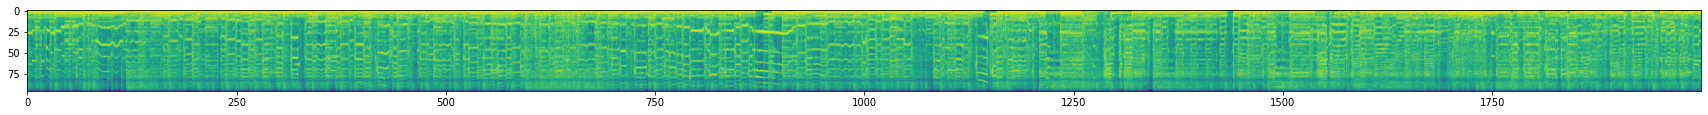

In [ ]:
plt.figure(figsize=(30,120))
plt.imshow(firstSample[:,4000:6000])

In [ ]:
tracksTrain[1007900]

{'album_id': 118623,
 'artist_id': 362548,
 'duration': 216.0,
 'genre': set(),
 'instrument': {'percussion'},
 'mood/theme': set(),
 'path': '00/1007900.mp3',
 'tags': ['instrument---percussion']}

In [ ]:
firstSample.shape[1] / tracksTrain[1007900]['duration']

46.879629629629626

#CRNN

In [ ]:
input = keras.Input(shape=(96, 141, 1))
crnn = layers.Conv2D(16, (3,3), activation='elu', padding='same')(input)
crnn = layers.BatchNormalization()(crnn)
crnn = layers.MaxPooling2D((2,2), padding='same')(crnn)
crnn = layers.Dropout(.2)(crnn)
crnn = layers.Conv2D(32, (3,5), activation='elu', padding='same')(crnn)
crnn = layers.BatchNormalization()(crnn)
crnn = layers.MaxPooling2D((2,2), padding='same')(crnn)
crnn = layers.Dropout(.2)(crnn)
crnn = layers.Conv2D(32, (5,9), activation='elu', padding='same')(crnn)
crnn = layers.BatchNormalization()(crnn)
crnn = layers.MaxPooling2D((2,2), padding='same')(crnn)
crnn = layers.Dropout(.2)(crnn)
crnn = layers.Permute((2, 1, 3))(crnn)
crnn = layers.Reshape((2000, -1))(crnn)

crnn = layers.Bidirectional(
 layers.GRU(100, activation='tanh', dropout=.2, recurrent_dropout=.2, return_sequences=True),
 merge_mode='concat')(crnn)
crnn = layers.Bidirectional(
 layers.GRU(64, activation='tanh', dropout=.2, recurrent_dropout=.2, return_sequences=True),
 merge_mode='concat')(crnn)
crnn = layers.TimeDistributed(layers.Dense(32))(crnn)
crnn = layers.Dropout(.2)(crnn)
crnn = layers.TimeDistributed(layers.Dense(16))(crnn)

output = layers.Activation('sigmoid', name='strong_out')(crnn)

In [ ]:
model = keras.Model(input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 96, 2000, 1)]     0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 96, 2000, 16)      160       
_________________________________________________________________
batch_normalization_45 (Batc (None, 96, 2000, 16)      64        
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 48, 1000, 16)      0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 48, 1000, 16)      0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 48, 1000, 32)      7712      
_________________________________________________________________
batch_normalization_46 (Batc (None, 48, 1000, 32)      128 

In [ ]:
earlystop = callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [ ]:
model.fit(x=, 
                epochs=50,
                batch_size=128,
                shuffle=True,
                verbose=1,
                validation_data=(testX, testX),
                callbacks=[earlystop])

#Upgraded to Colab Pro :)

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5044669603638230665, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15395979264
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17746508286150706384
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"]

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


#Training Steps

In [ ]:
import tensorflow as tf

In [ ]:
epochs = 200
batchSize = 256

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0003)
lossFunc = keras.losses.CategoricalCrossentropy(from_logits=True)

@tf.function
def trainStep(x, y, batch):
  avgLosses = tf.Variable(np.zeros(categories), dtype=np.float32)
  avgLogits = tf.Variable(np.zeros(categories), dtype=np.float32)

  sec = tf.constant(0, dtype=tf.int32)
  sample = tf.constant(0, dtype=tf.int32)

  while tf.less(sample, batch):
    slen = sample.shape[1] - 141
    losses = tf.Variable(np.zeros(categories), dtype=np.float32)
    logits = tf.Variable(np.zeros(categories), dtype=np.float32)
    while tf.less(sec, slen):
      with tf.GradientTape() as tape:
        logit = model(x[i][:,sec:sec+141])
        loss = lossFunc(x[i][:,sec:sec+141], y[i])
      sec += 141
      losses += loss
      logits += logit

    losses = losses / (slen // 141) 
    logits = logits / (slen // 141)

    avgLosses += losses
    avgLogits += logits
  
  avgLosses = avgLosses / batch
  avgLogits = avgLogits / batch

  grads = tape.gradient(avgLosses, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
  train_acc_metric.update_state(y, avgLogits)
  
  return loss

In [ ]:
#class CustomDataGen(keras.utils.Sequence):
  #def __init__(self, fnames, labels, batchSize):
    #self.fnames= fnames
    #self.labels = labels
    #self.batchSize = batchSize
    
  #def __len__(self):
    #return (np.ceil(len(self.fnames) / float(self.batchSize))).astype(np.int)
  
  #def __getitem__(self, index):

    #np.load("/content/drive/My Drive/Colab Notebooks/CompSoundMusic/mtg-jamendo-dataset/melspecs0/Volumes/HD-HSU2/multiInstrumentDetection/mel-spectrograms/

In [ ]:
for epoch in range(epochs):
  for steps_per_epoch():